In [1]:
# data import

# data preprocessing

# modeling 


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
import psycopg2

/home/olksndr/project/gallantra/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [4]:
conn = psycopg2.connect("host = localhost dbname = postgres user = postgres")

In [5]:
curr = conn.cursor()

In [6]:
curr.execute("""
select * from transactions
left join products on transactions.UPC = products.UPC
left join stores on transactions.STORE_NUM = stores.STORE_NUM;
""")

In [7]:
data = curr.fetchall()

In [8]:
conn.close()

In [9]:
with open('df_columns.txt', 'r') as file:
    cols = file.read()
columns = cols.split(',')

In [10]:
db = pd.DataFrame(data, columns = columns, )

In [11]:
db.head()

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,BASE_PRICE,PRICE,FEATURE,...,PRODUCT_SIZE,STORE_NUM_1,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,2009-01-14,367,1111009477,13,13,13,20.41,1.39,1.57,0,...,15 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12707
1,2009-01-14,367,1111009497,20,18,18,27.80,1.39,1.39,0,...,15 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12707
2,2009-01-14,367,1111009507,14,14,14,19.32,1.38,1.38,0,...,15 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12707
3,2009-01-14,367,1111035398,4,3,3,17.96,3.50,4.49,0,...,1.5 LT,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12707
4,2009-01-14,367,1111038078,3,3,3,7.50,2.50,2.50,0,...,500 ML,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12707


In [12]:
# well perform a prediction using PED for each product (or product category) 
#for each store separetly (or each store in the region, we'll check this, and choose the strategy depending 
#on results), then, validate it for the last two weeks.

In [13]:
db.WEEK_END_DATE = pd.to_datetime(db.WEEK_END_DATE)

In [14]:
last_two_weeks = db.WEEK_END_DATE.unique()[-2:]

In [15]:
last_two_weeks

array(['2011-12-28T00:00:00.000000000', '2012-01-04T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [86]:
test_sample = db[(db['WEEK_END_DATE'] == last_two_weeks[0])|(db['WEEK_END_DATE'] == last_two_weeks[1])]

In [17]:
db.shape

(538643, 27)

In [87]:
train_sample = db.drop(index=test_sample.index)

In [19]:
train_sample.shape[0] + test_sample.shape[0] == db.shape[0]

True

In [20]:
unique_stores = db.STORE_NUM.unique()

In [21]:
unique_stores[0]

367

In [22]:
unique_products = db.UPC.unique()

In [23]:
unique_products[0]

1111009477

In [24]:
train_data = train_sample[(train_sample.UPC == unique_products[0]) & (train_sample.STORE_NUM == unique_stores[0])]

In [25]:
test_data = test_sample[(test_sample.UPC == unique_products[0]) & (test_sample.STORE_NUM == unique_stores[0])]

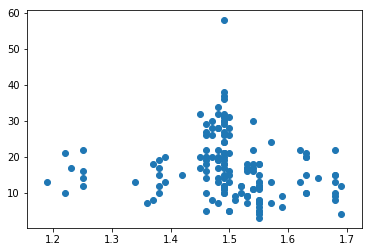

In [26]:
plt.scatter(train_data.PRICE, train_data.UNITS)


# let's perform the simplest fit

In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
lr = LinearRegression()

In [29]:
lr.fit(X=train_data[['PRICE']], y = train_data['UNITS'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

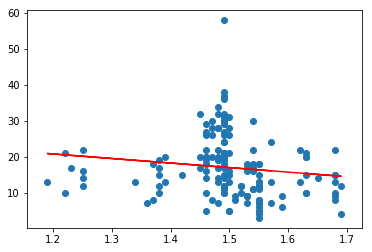

In [30]:
def f(x, linear_model):
    "This function is used to visualize a regression"
    return linear_model.intercept_+linear_model.coef_[0]*x

plt.scatter(train_data.PRICE, train_data.UNITS)
plt.plot(train_data.PRICE, f(train_data.PRICE, lr), 'r')

# and now lets extrapolate and interpret the result (add the formula)

In [31]:
x = np.arange(train_data.PRICE.min(), train_data.PRICE.max()+1, 0.01)
y = []

for i in range(x.shape[0]):
    y.append((x[i])*(lr.intercept_+lr.coef_[0]*x[i]))

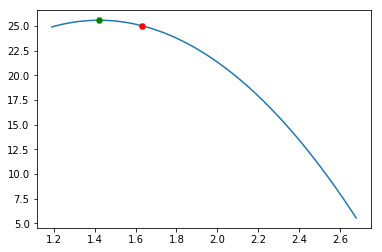

In [32]:
current_price, current_estimated_revenue = train_data.PRICE.iloc[-1], (train_data.PRICE.iloc[-1])*(lr.intercept_+lr.coef_[0]*train_data.PRICE.iloc[-1])

recommended_price, estimated_revenue = x[np.array(y).argmax(axis=0)], np.array(y).max()

test_data_price, test_data_revenue = test_data.PRICE, test_data.SPEND

plt.plot(x,y)
plt.plot(recommended_price, estimated_revenue, 'g H')
plt.plot(current_price, current_estimated_revenue, 'r H')

In [33]:
print('last observed price is {:.2f}\ncurrent estimated revenue is {:.2f}\nrecommended price is {:.2f}\
    \nestimated revenue is {:.2f}\nthe next two weeks prices are: {}, {}\
    \napplying recommended prices increases mean revenue by {:.2%}'\
      .format(current_price,
              current_estimated_revenue,
              recommended_price,
              estimated_revenue,
              test_data_price.values[0], test_data_price.values[1],
              ((estimated_revenue - test_data_revenue) / test_data_revenue).mean())
             )

last observed price is 1.63
current estimated revenue is 25.02
recommended price is 1.42    
estimated revenue is 25.57
the next two weeks prices are: 1.63, 1.6    
applying recommended prices increases mean revenue by 32.97%


# lets perform a fancier fit

In [35]:
import xgboost as xgb

In [53]:
db.ADDRESS_STATE_PROV_CODE.unique().tolist()

['KY', 'OH', 'TX', 'IN']

In [60]:
db.head(1)

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,BASE_PRICE,PRICE,FEATURE,...,PRODUCT_SIZE,STORE_NUM_1,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,2009-01-14,367,1111009477,13,13,13,20.41,1.39,1.57,0,...,15 OZ,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12707


In [59]:
db.columns

Index(['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS', 'VISITS', 'HHS', 'SPEND',
       'BASE_PRICE', 'PRICE', 'FEATURE', 'DISPLAY', 'TPR_ONLY', 'UPC_1',
       'DESCRIPTION', 'MANUFACTURER', 'CATEGORY', 'SUB_CATEGORY',
       'PRODUCT_SIZE', 'STORE_NUM_1', 'STORE_NAME', 'ADDRESS_CITY_NAME',
       'ADDRESS_STATE_PROV_CODE', 'MSA_CODE', 'SEG_VALUE_NAME',
       'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS'],
      dtype='object')

In [121]:
train_data = train_sample[(train_sample.UPC == unique_products[0]) ]

test_data = test_sample[(test_sample.UPC == unique_products[0]) ]

In [89]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()


enc.fit(train_data[['ADDRESS_STATE_PROV_CODE']])

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [122]:
state_one_hot = pd.DataFrame(enc.fit_transform(test_data[['ADDRESS_STATE_PROV_CODE']]).toarray(),
                       columns = test_data.ADDRESS_STATE_PROV_CODE.unique().tolist()).astype(int)

In [123]:
manufacturer_one_hot = pd.DataFrame(enc.fit_transform(test_data[['MANUFACTURER']]).toarray(),
                       columns = test_data.MANUFACTURER.unique().tolist()).astype(int)


In [95]:
manfacturer_one_hot.head()

,PRIVATE LABEL,GENERAL MI,FRITO LAY,QUAKER,P & G,KELLOGG,CHATTEM,SHULTZ,TOMBSTONE,TONYS,SNYDER S,WARNER,MKSL,COLGATE,POST FOODS,KING
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [124]:
train_data = train_data.drop(['UPC_1', 'DESCRIPTION', 'MANUFACTURER', 'CATEGORY', 'SUB_CATEGORY',
       'PRODUCT_SIZE','STORE_NUM_1','STORE_NAME', 'ADDRESS_CITY_NAME', 'ADDRESS_STATE_PROV_CODE',
                'MSA_CODE', 'SEG_VALUE_NAME'], axis = 1)

test_data = test_data.drop(['UPC_1', 'DESCRIPTION', 'MANUFACTURER', 'CATEGORY', 'SUB_CATEGORY',
       'PRODUCT_SIZE','STORE_NUM_1','STORE_NAME', 'ADDRESS_CITY_NAME', 'ADDRESS_STATE_PROV_CODE',
                'MSA_CODE', 'SEG_VALUE_NAME'], axis = 1)

In [125]:
#train_data = train_data.join(state_one_hot, how='left').join(manufacturer_one_hot, how = 'left')
#data = data.join(state_one_hot, how='left').join(manufacturer_one_hot, how = 'left')
test_data = test_data.join(state_one_hot, how='left').join(manufacturer_one_hot, how = 'left')

In [110]:
train_data.columns

Index(['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS', 'VISITS', 'HHS', 'SPEND',
       'BASE_PRICE', 'PRICE', 'FEATURE', 'DISPLAY', 'TPR_ONLY',
       'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS', 'KY',
       'OH', 'TX', 'IN', 'PRIVATE LABEL'],
      dtype='object')

In [126]:
test_data.columns

Index(['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS', 'VISITS', 'HHS', 'SPEND',
       'BASE_PRICE', 'PRICE', 'FEATURE', 'DISPLAY', 'TPR_ONLY',
       'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS', 'KY',
       'OH', 'TX', 'IN', 'PRIVATE LABEL'],
      dtype='object')

In [103]:
y_train = data['UNITS']

In [131]:
y_test = test_sample.UNITS[test_sample.UPC ==unique_products[0]]

In [104]:
X_train = data.drop(['WEEK_END_DATE','SPEND', 'UNITS', 'VISITS', 'HHS', 'BASE_PRICE'], axis = 1)

In [128]:
test_data.drop(['UNITS', 'VISITS', 'HHS', 'SPEND','BASE_PRICE', 'WEEK_END_DATE'], axis = 1)

,STORE_NUM,UPC,PRICE,FEATURE,DISPLAY,TPR_ONLY,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS,KY,OH,TX,IN,PRIVATE LABEL
531962,367,1111009477,1.63,0,0,0,196.0,24721,12707,NaN,NaN,NaN,NaN,NaN
531995,387,1111009477,1.63,0,0,0,270.0,44547,22867,NaN,NaN,NaN,NaN,NaN
532041,389,1111009477,1.62,0,0,0,408.0,46073,24767,NaN,NaN,NaN,NaN,NaN
532088,613,1111009477,1.46,0,0,0,464.0,64926,29386,NaN,NaN,NaN,NaN,NaN
532131,623,1111009477,1.22,0,0,0,NaN,46930,36741,NaN,NaN,NaN,NaN,NaN
532175,2277,1111009477,1.62,0,1,0,NaN,81958,54053,NaN,NaN,NaN,NaN,NaN
532225,2279,1111009477,1.55,0,1,0,771.0,44175,23037,NaN,NaN,NaN,NaN,NaN
532266,2281,1111009477,1.62,0,0,0,NaN,68500,32297,NaN,NaN,NaN,NaN,NaN
532317,2495,1111009477,1.23,0,0,0,407.0,48462,25507,NaN,NaN,NaN,NaN,NaN
532356,2505,1111009477,1.23,0,0,0,319.0,41644,14460,NaN,NaN,NaN,NaN,NaN


In [116]:
params = {'max_depth':3,
'min_child_weight':10,
'learning_rate':0.3,
'subsample':0.5,
'colsample_bytree':0.6,
'obj':'reg:linear',
'n_estimators':1000,
'eta':0.3}

In [135]:
test_data.columns
y_test = test_data.UNITS

In [136]:
X_test = test_data.drop(['UNITS', 'VISITS', 'HHS', 'SPEND','BASE_PRICE', 'WEEK_END_DATE'], axis = 1)

In [137]:
features = X_test
target = y_test
dmatrix = xgb.DMatrix(features.values,
                     target.values,
                     feature_names=features.columns.values)

In [118]:
clf = xgb.train(params, dmatrix)

[02:59:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:59:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:59:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:59:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:59:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[02:59:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:00:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:00:00] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[03:00:00] /work

In [141]:
clf.predict(xgb.DMatrix(X_test.values))

ValueError: feature_names mismatch: ['STORE_NUM', 'UPC', 'PRICE', 'FEATURE', 'DISPLAY', 'TPR_ONLY', 'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS', 'KY', 'OH', 'TX', 'IN', 'PRIVATE LABEL', 'GENERAL MI', 'FRITO LAY', 'QUAKER', 'P & G', 'KELLOGG', 'CHATTEM', 'SHULTZ', 'TOMBSTONE', 'TONYS', 'SNYDER S', 'WARNER', 'MKSL', 'COLGATE', 'POST FOODS', 'KING'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13']
expected WARNER, TPR_ONLY, TOMBSTONE, PARKING_SPACE_QTY, KING, AVG_WEEKLY_BASKETS, SHULTZ, GENERAL MI, QUAKER, TONYS, PRIVATE LABEL, KELLOGG, KY, CHATTEM, FEATURE, SNYDER S, STORE_NUM, COLGATE, IN, UPC, OH, SALES_AREA_SIZE_NUM, POST FOODS, TX, PRICE, FRITO LAY, DISPLAY, P & G, MKSL in input data
training data did not have the following fields: f0, f6, f8, f5, f4, f9, f13, f7, f12, f1, f2, f11, f10, f3

In [140]:
xgb.DMatrix(X_test.values)